In [7]:
import math
import random
from collections import Counter
from matplotlib import pyplot as plt

In [8]:
def bucketize(point, bucket_size):
    """floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

In [9]:
def make_histogram(points, bucket_size):
    """buckets the point and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

In [10]:
def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

In [11]:
def normal_cdf(x, mu = 0, sigma = 1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

In [12]:
def inverse_normal_cdf(p, mu = 0, sigma = 1, tolerance = 0.00001):
    """find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance = tolerance)

    low_z, low_p = -10.0, 0         # normal_cdf(-10) is (very close to) 0
    hi_z, hi_p = 10.0, 1            # normal_cdf(10) is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2  # consider the midpoint
        mid_p = normal_cdf(mid_z)   # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break

    return mid_z

In [13]:
random.seed(0)

# uniform between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# normal distribution with mean 0, standard deviation 57
normal = [57 * inverse_normal_cdf(random.random())
         for _ in range(10000)]

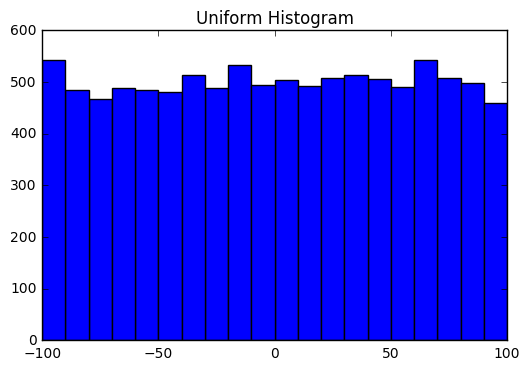

In [14]:
plot_histogram(uniform, 10, "Uniform Histogram")

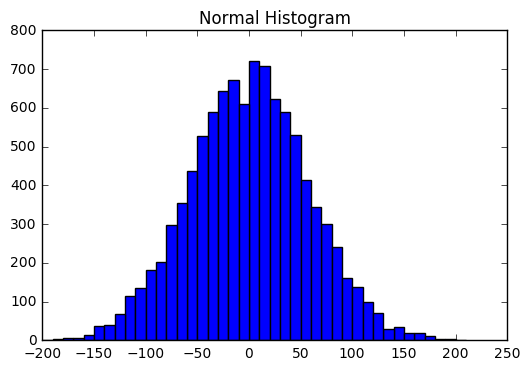

In [15]:
plot_histogram(normal, 10, "Normal Histogram")

In [16]:
def random_normal():
    """returns a random draw from a standard normal distribution"""
    return inverse_normal_cdf(random.random())

In [17]:
xs = [random_normal() for _ in range(10000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

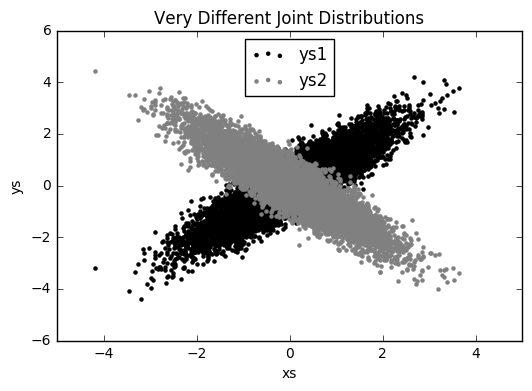

In [18]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

In [19]:
def mean(x):
    return sum(x) / len(x)

In [20]:
def de_mean(x):
    """translate x by subtracting its mean (so the result has mean of 0)"""
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

In [21]:
def variance(x):
    """assumes x has at least two elements"""
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations) / (n - 1)

In [22]:
def standard_deviation(x):
    return math.sqrt(variance(x))

In [23]:
def covariance(x, y):
    n = len(x)
    return dot(de_mean(x), de_mean(y)) / (n - 1)

In [24]:
def correlation(x, y):
    stdev_x = standard_deviation(x)
    stdev_y = standard_deviation(y)

    if stdev_x > 0 and stdev_y > 0:
        return covariance(x, y) / stdev_x / stdev_y
    else:
        return 0 # if no variation, correlation is zero

In [25]:
def dot(v, w):
    """v_1 * w_1 + ...  + v_n * w_n"""
    return sum(v_i * w_i
        for v_i, w_i in zip(v, w))

In [26]:
def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

In [27]:
def shape(A):
    num_rows = len(A)
    num_cols = len(A[0]) if A else 0  # number of elements in the first row
    return num_rows, num_cols

In [28]:
print(correlation(xs, ys1)) # 0.9
print(correlation(xs, ys2)) # -0.9

0.8925806189227748
-0.8956130066187867


In [29]:
def correlation_matrix(data):
    """returns the num_columns x num_columns matrix whose (i, j)th entry is the correlation between columns i and j of data"""
    _, num_columns = shape(data)
    
    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))
    
    return make_matrix(num_columns, num_columns, matrix_entry)

In [30]:
def parse_row(input_row, parsers):
    """given a list of parsers (some of which may be None)
        apply the appropriate one to each element of the input_row"""   
    return [try_or_none(parser)(value) if parser is not None else
        value for value, parser in zip(input_row, parsers)]

In [31]:
def parse_rows_with(reader, parsers):
    """wrap a reader to apply the parsers to each of its rows"""  
    for row in reader:
        yield parse_row(row, parsers)

In [32]:
def try_or_none(f):
    """wrap f to return None if f raises an exception
    assumes f takes only one input"""
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none

In [33]:
import csv
import dateutil.parser
data = []

with open("comma_delimited_stock_prices.csv", "rt") as f:
    reader = csv.reader(f)
    for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)
    
    for row in data:
        if any(x is None for x in row):
            print(row)

[datetime.datetime(2014, 6, 19, 0, 0), 'MSFT', None]


In [34]:
def try_parse_field(field_name, value, parser_dict):
    """try to parse value using the appropriate function from
    parser_dict"""
    parser = parser_dict.get(field_name) # None if no such entry
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value

In [35]:
def parse_dict(input_dict, parser_dict):
    return { field_name : try_parse_field(field_name, value, parser_dict)
        for field_name, value in input_dict.iteritems() }

In [36]:
def picker(field_name):
    """returns a function that picks a field out of a dict"""
    return lambda row: row[field_name]

In [37]:
def pluck(field_name, rows):
    """turn a list of dicts into the list of field_name values"""
    return map(picker(field_name), rows)

In [45]:
def group_by(grouper, rows, value_transform=None):
    # key is output of grouper, value is list of rows
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
    
    if value_transform is None:
            return grouped
    else:
        return { key: value_transform(rows)
            for key, rows in grouped.items()}

In [50]:
import datetime

data = [
    {'closing_price': 102.06,
    'date': datetime.datetime(2014, 8, 29, 0, 0),
    'symbol': 'AAPL'},
    {'closing_price': 91.86,
    'date': datetime.datetime(2014, 6, 19, 0, 0),
    'symbol': 'AAPL'},
    {'closing_price': 41.68,
    'date': datetime.datetime(2014, 6, 20, 0, 0),
    'symbol': 'MSFT'},
    {'closing_price': 42.12,
    'date': datetime.datetime(2014, 6, 21, 0, 0),
    'symbol': 'MSFT'},
    {'closing_price': 102.06,
    'date': datetime.datetime(2014, 8, 29, 0, 0),
    'symbol': 'RHAT'},
    {'closing_price': 101.76,
    'date': datetime.datetime(2014, 8, 28, 0, 0),
    'symbol': 'RHAT'},
    {'closing_price': 99.82,
    'date': datetime.datetime(2014, 9, 15, 0, 0),
    'symbol': 'RHAT'},
    {'closing_price': 105.70,
    'date': datetime.datetime(2014, 9, 21, 0, 0),
    'symbol': 'RHAT'},
    {'closing_price': 103.59,
    'date': datetime.datetime(2014, 9, 15, 0, 0),
    'symbol': 'AAPL'},
    {'closing_price': 100.49,
    'date': datetime.datetime(2014, 9, 21, 0, 0),
    'symbol': 'AAPL'},
    {'closing_price': 45.38,
    'date': datetime.datetime(2014, 9, 15, 0, 0),
    'symbol': 'MSFT'},
    {'closing_price': 52.98,
    'date': datetime.datetime(2014, 9, 21, 0, 0),
    'symbol': 'MSFT'},
]

max_price_by_symbol = group_by(picker("symbol"),
                data,
                lambda rows: max(pluck("closing_price", rows)))

print(max_price_by_symbol)

{'RHAT': 105.7, 'MSFT': 52.98, 'AAPL': 103.59}


In [51]:
def percent_price_change(yesterday, today):
    return today["closing_price"] / yesterday["closing_price"] - 1

In [52]:
def day_over_day_changes(grouped_rows):
    # sort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))
    
    # zip with an offset to get pairs of consecutive days
    return [{ "symbol": today["symbol"],
        "date": today["date"],
        "change": percent_price_change(yesterday, today)}
        for yesterday, today in zip(ordered, ordered[1:])]

In [53]:
# key is symbol, value is list of "change" dicts
changes_by_symbol = group_by(picker("symbol"), data, day_over_day_changes)

# collect all "change" dicts into one big list
all_changes = [change
    for changes in changes_by_symbol.values()
    for change in changes]

In [54]:
max(all_changes, key=picker("change"))

{'change': 0.16747465843984122,
 'date': datetime.datetime(2014, 9, 21, 0, 0),
 'symbol': 'MSFT'}

In [55]:
min(all_changes, key=picker("change"))

{'change': -0.02992566850082068,
 'date': datetime.datetime(2014, 9, 21, 0, 0),
 'symbol': 'AAPL'}

In [68]:
from functools import reduce

# to combine percent changes, we add 1 to each, multiply them, and subtract 1
# for instance, if we combine +10% and -20%, the overall change is
# (1 + 10%) * (1 - 20%) - 1= 1.1 * .8 - 1 = -12%
def combine_pct_changes(pct_change1, pct_change2):
    return (1 + pct_change1) * (1 + pct_change2) - 1

def overall_change(changes):
    return reduce(combine_pct_changes, pluck("change", changes))

In [70]:
overall_change_by_month = group_by(lambda row: row['date'].month, all_changes, overall_change)

print(overall_change_by_month)

{8: 0.11431400428872474, 9: 0.2826562952047247, 6: 0.01055662188099804}


In [71]:
def scale(data_matrix):
    """returns the means and standard deviations of each column"""
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix, j))
        for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix, j))
        for j in range(num_cols)]
    return means, stdevs

In [72]:
def rescale(data_matrix):
    """rescales the input data so that each column has mean 0 and standard deviation 1
    leaves alone columns with no deviation"""
    means, stdevs = scale(data_matrix)
    
    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
                return data_matrix[i][j]
    
    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)